In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import statsmodels.stats.diagnostic as diag
from statsmodels.stats.diagnostic import acorr_breusch_godfrey
# from statsmodels.stats.diagnostic import breusch_godfrey
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from tabulate import tabulate
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv('C:/Users/dhruv/Documents/School/Time Series/code/finalData.csv', index_col='dates', parse_dates=True)
overall = df
overall = overall.drop(columns=['Top 10 Gross', 'Week', 'Overall Gross', 'cpi', 'Real Value for Overall'])
overall

,Real Value for Top 10
dates,
2000-04-01,1.100941e+09
2000-07-01,1.606602e+09
2000-10-01,1.511005e+09
2001-01-01,1.860802e+09
2001-04-01,1.183940e+09
...,...
2021-10-01,1.306386e+09
2022-01-01,1.860708e+09
2022-04-01,1.210187e+09


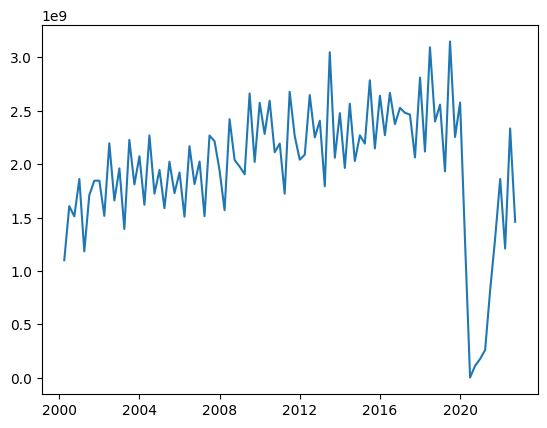

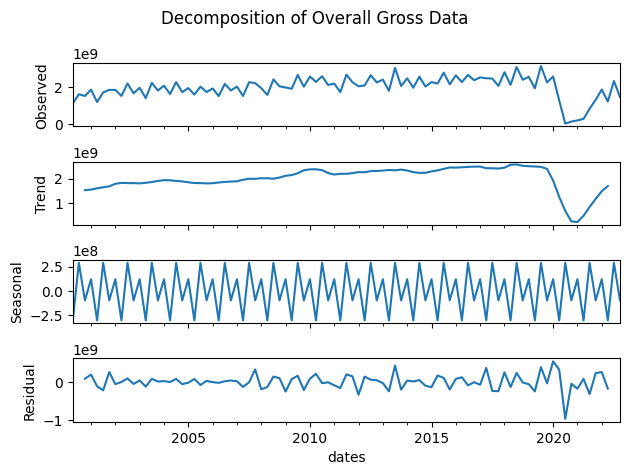

In [4]:
plt.plot(overall)
# Decompose the time series using an additive model
decomposition = seasonal_decompose(overall['Real Value for Top 10'], model='additive')

# Plot the decomposed data
fig, axes = plt.subplots(nrows=4, ncols=1, sharex=True)
decomposition.observed.plot(ax=axes[0], legend=False)
axes[0].set_ylabel('Observed')
decomposition.trend.plot(ax=axes[1], legend=False)
axes[1].set_ylabel('Trend')
decomposition.seasonal.plot(ax=axes[2], legend=False)
axes[2].set_ylabel('Seasonal')
decomposition.resid.plot(ax=axes[3], legend=False)
axes[3].set_ylabel('Residual')
fig.suptitle('Decomposition of Overall Gross Data', fontsize=12)
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Deseasonalized Time Series')

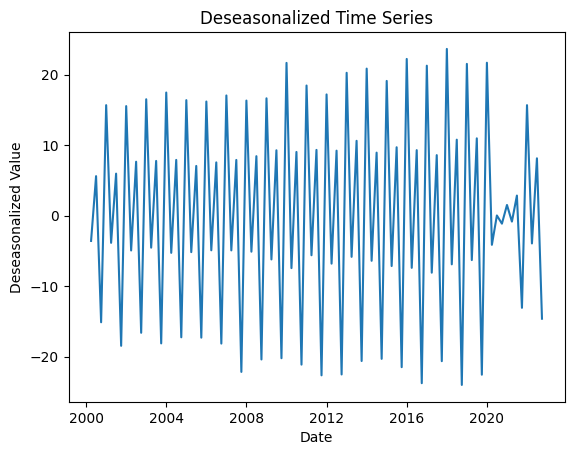

In [6]:
# Deseasonalize the data using the previously computed decomposition
deseasonalized = overall['Real Value for Top 10'] / decomposition.seasonal

# Plot the deseasonalized time series 
fig, ax = plt.subplots()
ax.plot(deseasonalized)
ax.set_ylabel('Deseasonalized Value')
ax.set_xlabel('Date')
ax.set_title('Deseasonalized Time Series')

# Display the plot
# plt.show()

In [7]:
# Testing for unit root with the ADF test
# 'nc': no constant term, 'c': constant term only, ct': constant and linear trend
# lines up with the none, drift, and trend models in R
models = ['n', 'c', 'ct']
results = []
for model in models:
    result = adfuller(deseasonalized, regression=model, autolag='AIC', maxlag=10)
    results.append([model, result[0], result[1], result[4]['5%']])

# Print results in a table
results.append([model, result[0], result[1], result[4]['5%']])

# Print results in a table
headers = ['Model', 'ADF Statistic','p-value','5% Critical Value']
print(tabulate(results[:-1], headers=headers)) #already stationary??

Model      ADF Statistic      p-value    5% Critical Value
-------  ---------------  -----------  -------------------
n               -2.21306  0.0258412               -1.94482
c               -5.14545  1.13504e-05             -2.89662
ct              -5.38289  3.90939e-05             -3.46411


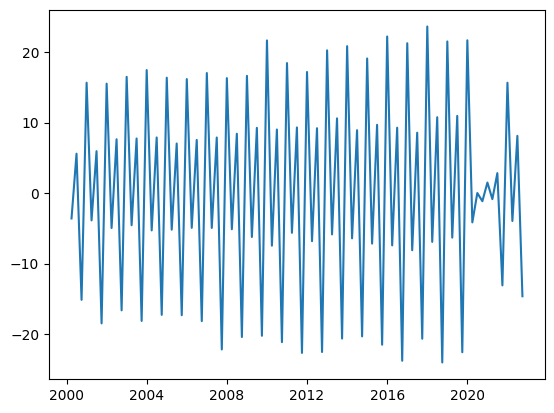

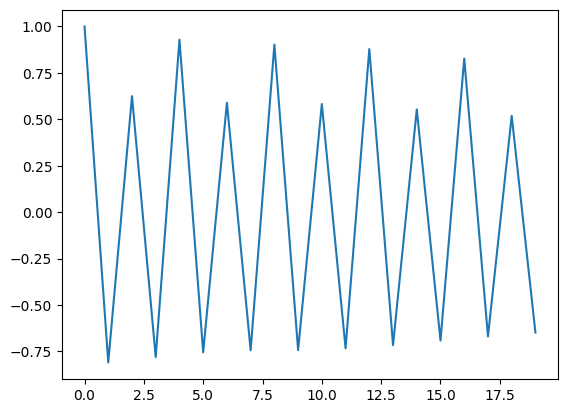

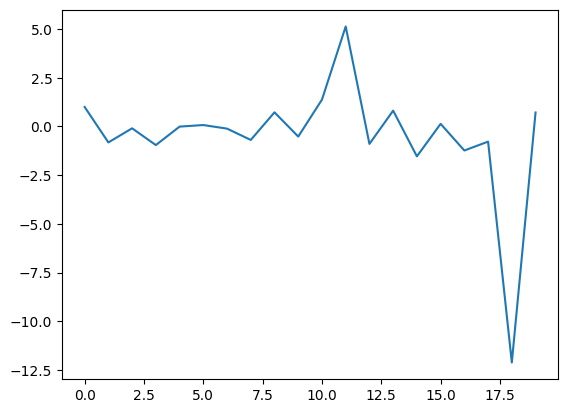

   lag         AIC         BIC
0    1  649.111303  656.643881
1    2  650.221196  660.264634
2    3  476.922432  489.476729
3    4  478.620641  493.685798
4    5  472.864958  490.440975
5    6  474.535682  494.622558
6    7  458.951091  481.548826
7    8  460.515606  485.624201


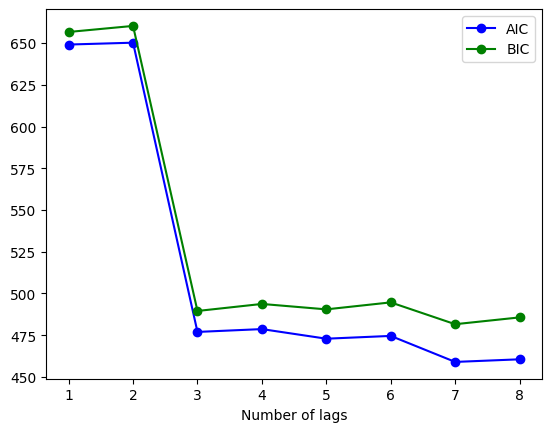

In [9]:
# Generate plots of the time series
plt.plot(deseasonalized)
plt.show()
plt.plot(acf(deseasonalized))
plt.show()
plt.plot(pacf(deseasonalized))
plt.show()

# Select optimal number of lags using AIC and BIC
T = len(deseasonalized)
pmax = 8
p = np.arange(1, pmax + 1)
aic = np.zeros(len(p))
bic = np.zeros(len(p))

for i in range(len(p)):
    model = ARIMA(deseasonalized, order=(p[i], 0, 0)).fit()
    aic[i] = model.aic
    bic[i] = model.bic

select = pd.DataFrame({'lag': p, 'AIC': aic, 'BIC': bic})
print(select)

plt.plot(p, aic, 'bo-', label='AIC')
plt.plot(p, bic, 'go-', label='BIC')
plt.xlabel('Number of lags')
plt.legend()
plt.show()

In [11]:
# Select optimal number of lags using auto_arima
model = auto_arima(deseasonalized, start_p=1, start_q=1,
                   max_p=8, max_q=8, d=None, seasonal=False,
                   trace=True, error_action='ignore', suppress_warnings=True,
                   stepwise=True, information_criterion='aic')
print(model.summary())
print(model.aic())
print(model.bic())
# plt.plot(model.aic(), 'bo-', label='AIC')
# plt.plot(model.bic(), 'go-', label='BIC')
# plt.xlabel('Number of lags')
# plt.legend()
# plt.show()

model2 = auto_arima(deseasonalized, start_p=1, start_q=1,
                   max_p=8, max_q=8, d=None, seasonal=False,
                   trace=True, error_action='ignore', suppress_warnings=True,
                   stepwise=True, information_criterion='bic')
print(model2.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=620.144, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=743.330, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=647.442, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=657.627, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=622.106, Time=0.04 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=608.490, Time=0.06 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=608.372, Time=0.08 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=579.188, Time=0.08 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=577.684, Time=0.11 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.15 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=458.677, Time=0.22 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=458.863, Time=0.19 sec
 ARIMA(4,0,3)(0,0,0)[0]             : AIC=462.368, Time=0.24 sec
 ARIMA(3,0,4)(0,0,0)[0]             : AIC=456.302, Time

In [13]:
y = pd.Series(deseasonalized)
final = ARIMA(y, order=(3, 0, 4)).fit()
forecast_values = final.forecast(steps=3)

print("Forecasted values:", forecast_values)

import statsmodels.api as sm

# Create a linear regression model object and obtain residuals
fe = sm.OLS(final.resid, np.ones_like(final.resid)).fit()

# Create two arrays of length 12 to store test statistics and p-values
a = np.zeros(12)
b = np.zeros(12)

# Loop over lags 1 to 12 and perform the Breusch-Godfrey test for each lag
for p in range(1, 13):
    bg = sm.stats.diagnostic.acorr_breusch_godfrey(fe, nlags=p)
    a[p-1] = bg[0]   # Store test statistic
    b[p-1] = bg[1]   # Store p-value

# Combine the results into a data frame
results = pd.DataFrame({'Lag': range(1, 13), 'Test Statistic': a, 'p-value': b})
print(results)   # Print the results


Forecasted values: 2023-01-01    11.702505
2023-04-01    -1.394973
2023-07-01     5.058751
Freq: QS-OCT, Name: predicted_mean, dtype: float64
    Lag  Test Statistic   p-value
0     1        0.504540  0.477512
1     2        1.339085  0.511943
2     3        1.383627  0.709377
3     4        1.550606  0.817641
4     5        2.571725  0.765656
5     6        2.856136  0.826675
6     7        2.870938  0.896679
7     8        2.929983  0.938674
8     9        2.963002  0.965744
9    10        3.245158  0.975052
10   11        3.412398  0.984078
11   12        3.440944  0.991549
